In [4]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
!chmod 600 /content/kaggle.json

In [7]:
!kaggle datasets download -d parthplc/medical-image-dataset -p /content/kaggle/input

 38% 5.00M/13.0M [00:00<00:00, 48.5MB/s]
100% 13.0M/13.0M [00:00<00:00, 105MB/s] 


In [8]:
!unzip /content/kaggle/input/medical-image-dataset.zip -d /content/kaggle/input

Archive:  /content/kaggle/input/medical-image-dataset.zip
  inflating: /content/kaggle/input/Dataset/1.jpg  
  inflating: /content/kaggle/input/Dataset/10.jpg  
  inflating: /content/kaggle/input/Dataset/100.jpg  
  inflating: /content/kaggle/input/Dataset/101.jpg  
  inflating: /content/kaggle/input/Dataset/102.jpg  
  inflating: /content/kaggle/input/Dataset/103.jpg  
  inflating: /content/kaggle/input/Dataset/104.jpg  
  inflating: /content/kaggle/input/Dataset/105.jpg  
  inflating: /content/kaggle/input/Dataset/106.jpg  
  inflating: /content/kaggle/input/Dataset/107.jpg  
  inflating: /content/kaggle/input/Dataset/108.jpg  
  inflating: /content/kaggle/input/Dataset/109.jpg  
  inflating: /content/kaggle/input/Dataset/11.jpg  
  inflating: /content/kaggle/input/Dataset/110.jpg  
  inflating: /content/kaggle/input/Dataset/111.jpg  
  inflating: /content/kaggle/input/Dataset/112.jpg  
  inflating: /content/kaggle/input/Dataset/113.jpg  
  inflating: /content/kaggle/input/Dataset/11

In [10]:
# Ler as imagens na pasta
import numpy as np
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/content/kaggle/input/Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/kaggle/input/Dataset/74.jpg
/content/kaggle/input/Dataset/22.jpg
/content/kaggle/input/Dataset/15.jpg
/content/kaggle/input/Dataset/3.jpg
/content/kaggle/input/Dataset/48.jpg
/content/kaggle/input/Dataset/9.jpg
/content/kaggle/input/Dataset/14.jpg
/content/kaggle/input/Dataset/84.jpg
/content/kaggle/input/Dataset/106.jpg
/content/kaggle/input/Dataset/44.jpg
/content/kaggle/input/Dataset/2.jpg
/content/kaggle/input/Dataset/23.jpg
/content/kaggle/input/Dataset/83.jpg
/content/kaggle/input/Dataset/109.jpg
/content/kaggle/input/Dataset/72.jpg
/content/kaggle/input/Dataset/73.jpg
/content/kaggle/input/Dataset/18.jpg
/content/kaggle/input/Dataset/88.jpg
/content/kaggle/input/Dataset/92.jpg
/content/kaggle/input/Dataset/101.jpg
/content/kaggle/input/Dataset/76.jpg
/content/kaggle/input/Dataset/100.jpg
/content/kaggle/input/Dataset/19.jpg
/content/kaggle/input/Dataset/85.jpg
/content/kaggle/input/Dataset/57.jpg
/content/kaggle/input/Dataset/71.jpg
/content/kaggle/input/Dataset/56.jpg


In [57]:
from keras.preprocessing import image
import matplotlib.pyplot as plt

train_images = sorted(os.listdir('./kaggle/input/Dataset'))

train_image = []
for im in train_images:
    # Ler imagem
    img = image.load_img('./kaggle/input/Dataset/'+ im, target_size=(128,128), color_mode= 'grayscale')
    # Transformar em array por causa do tf
    img = image.img_to_array(img)
    # Normalizar imagens (0-1)
    img = img/255
    train_image.append(img)

train_df = np.array(train_image)

# Add o ruido nas imagens
def add_noice(image):
    row,col,ch= image.shape
    mean = 0
    sigma = 1
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss*0.07
    return noisy

# Funcao para visualização de imagens
def show_img(dataset):
    f, ax = plt.subplots(1,5)
    f.set_size_inches(40, 20)
    for i in range(5,10):
        ax[i-5].imshow(dataset[i].reshape(128,128), cmap='gray')
    plt.show()

In [35]:
noised_df= []

for img in train_df:
    noisy= add_noice(img)
    noised_df.append(noisy)

noised_df= np.array(noised_df)

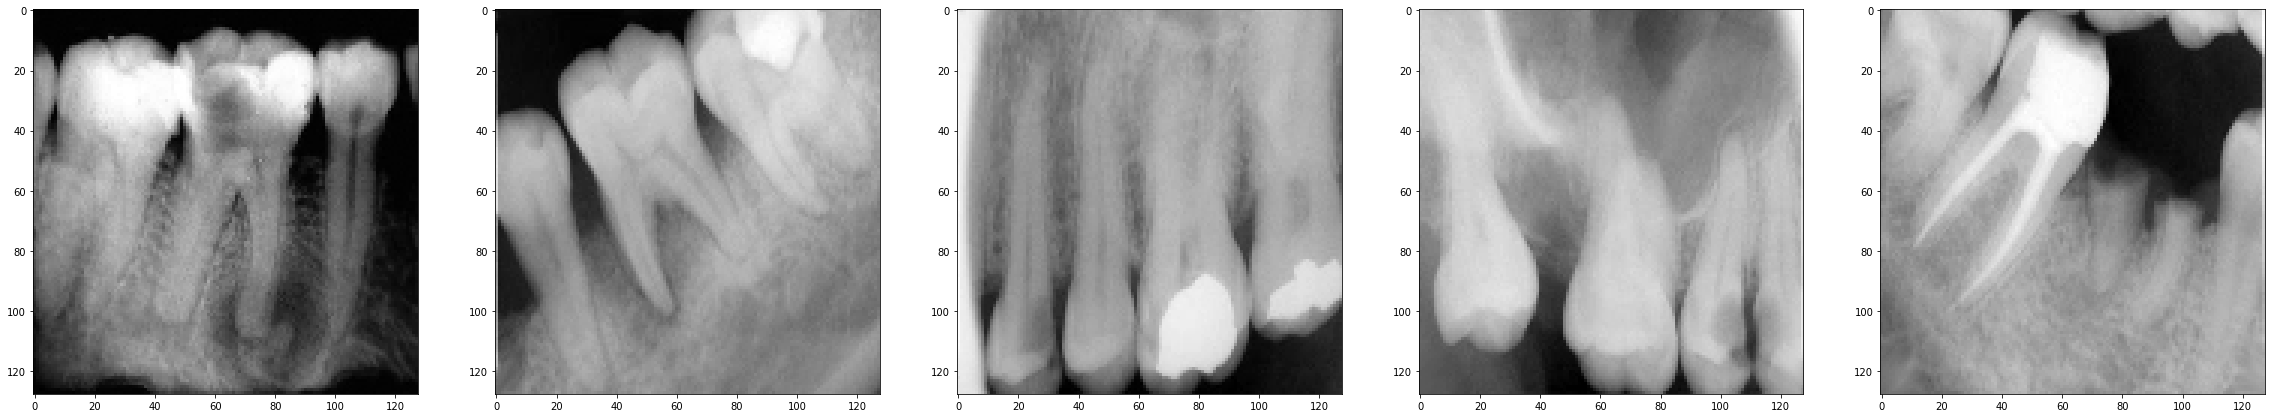

In [37]:
show_img(train_df)

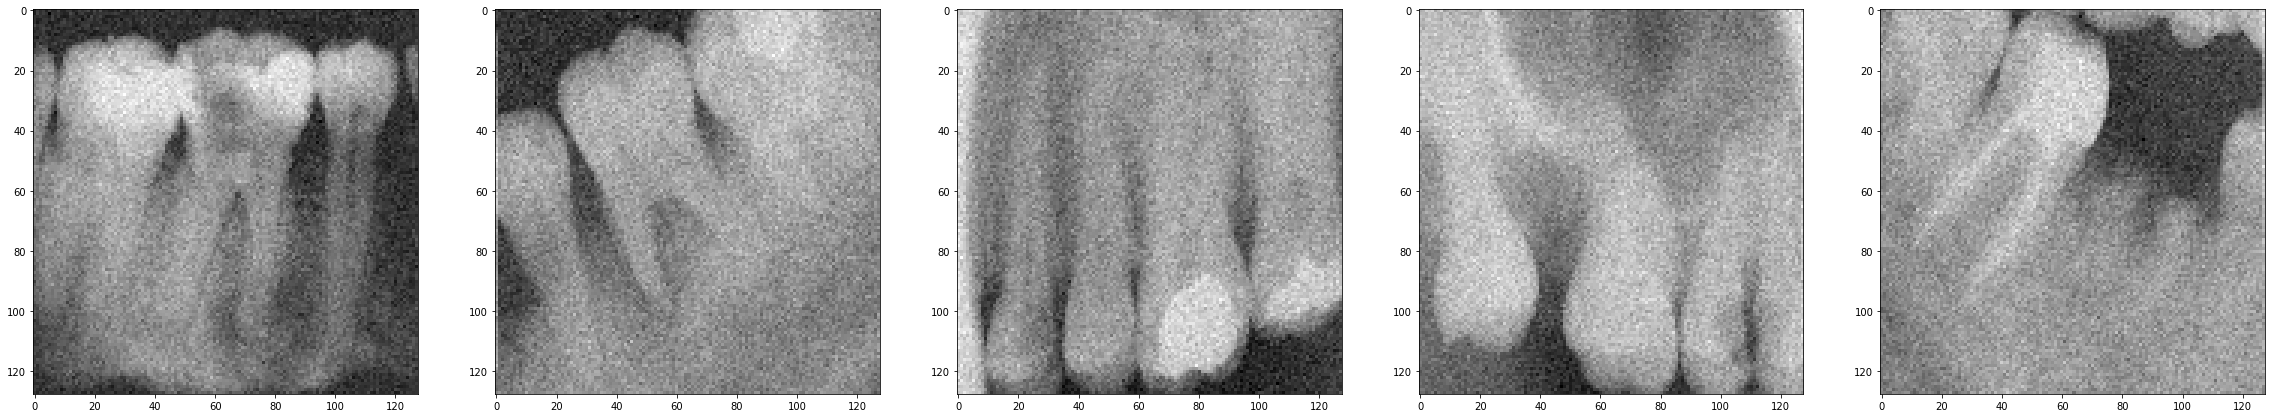

In [38]:
show_img(noised_df)

In [39]:
# Seperando em treino e teste
xnoised = noised_df[0:100]
xtest = noised_df[100:]

In [41]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D,MaxPool2D ,UpSampling2D, Flatten, Input
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, Adagrad
from keras import backend as K

def autoencoder():
    
    input_img = Input(shape=(128,128,1), name='image_input')
    
    #enoder 
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = MaxPooling2D((2,2), padding='same', name='pool2')(x)
    
    #decoder
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv3')(x)
    x = UpSampling2D((2,2), name='upsample1')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv4')(x)
    x = UpSampling2D((2,2), name='upsample2')(x)
    x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv5')(x)
    
    #model
    autoencoder = Model(inputs=input_img, outputs=x)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    return autoencoder

model= autoencoder()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 128, 128, 1)]     0         
                                                                 
 Conv1 (Conv2D)              (None, 128, 128, 64)      640       
                                                                 
 pool1 (MaxPooling2D)        (None, 64, 64, 64)        0         
                                                                 
 Conv2 (Conv2D)              (None, 64, 64, 64)        36928     
                                                                 
 pool2 (MaxPooling2D)        (None, 32, 32, 64)        0         
                                                                 
 Conv3 (Conv2D)              (None, 32, 32, 64)        36928     
                                                                 
 upsample1 (UpSampling2D)    (None, 64, 64, 64)        0   

In [42]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

with tf.device('/device:GPU:0'):
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
    model.fit(xnoised, xnoised, epochs=40, batch_size=10, validation_data=(xtest, xtest), callbacks=[early_stopping])

Epoch 1/40
10/10 [==============================] - 1s 30ms/step - loss: 0.6658 - val_loss: 0.6124
Epoch 2/40
10/10 [==============================] - 0s 18ms/step - loss: 0.5959 - val_loss: 0.5796
Epoch 3/40
10/10 [==============================] - 0s 19ms/step - loss: 0.5754 - val_loss: 0.5729
Epoch 4/40
10/10 [==============================] - 0s 18ms/step - loss: 0.5691 - val_loss: 0.5709
Epoch 5/40
10/10 [==============================] - 0s 18ms/step - loss: 0.5652 - val_loss: 0.5687
Epoch 6/40
10/10 [==============================] - 0s 18ms/step - loss: 0.5638 - val_loss: 0.5646
Epoch 7/40
10/10 [==============================] - 0s 17ms/step - loss: 0.5616 - val_loss: 0.5641
Epoch 8/40
10/10 [==============================] - 0s 18ms/step - loss: 0.5603 - val_loss: 0.5623
Epoch 9/40
10/10 [==============================] - 0s 18ms/step - loss: 0.5591 - val_loss: 0.5612
Epoch 10/40
10/10 [==============================] - 0s 19ms/step - loss: 0.5586 - val_loss: 0.5610
Epoch 11/

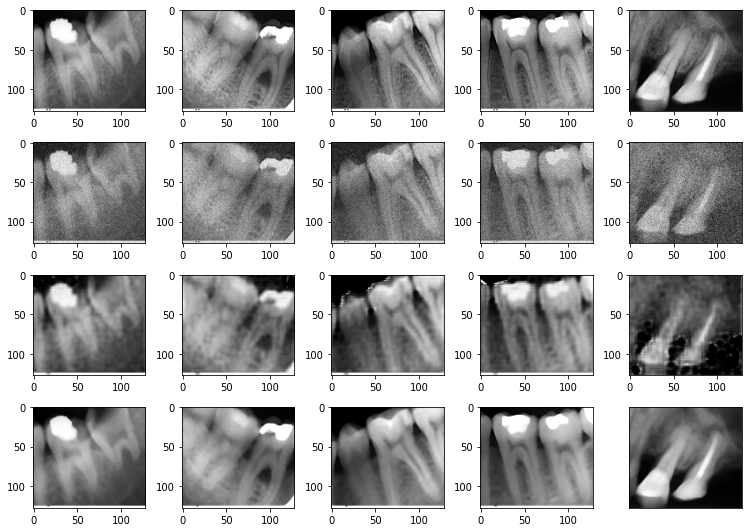

In [72]:
import cv2

xtrain = train_df[100:]

pred = model.predict(xtest)

def plot_predictions(y_true, y_pred):    
    f, ax = plt.subplots(4, 5)
    f.set_size_inches(10.5,7.5)
    for i in range(5):
        ax[0][i].imshow(np.reshape(xtrain[i], (128,128)), aspect='auto', cmap='gray') # Imagem Original
        ax[1][i].imshow(np.reshape(y_true[i], (128,128)), aspect='auto', cmap='gray') # Imagem de teste
        ax[2][i].imshow(np.reshape(y_pred[i], (128,128)), aspect='auto', cmap='gray') # Imagem Predita
        ax[3][i].imshow(cv2.medianBlur(xtrain[i], (5)), aspect='auto', cmap='gray')   # Filtro 

       
    plt.tight_layout()
plot_predictions(xtest[:5], pred[:5])

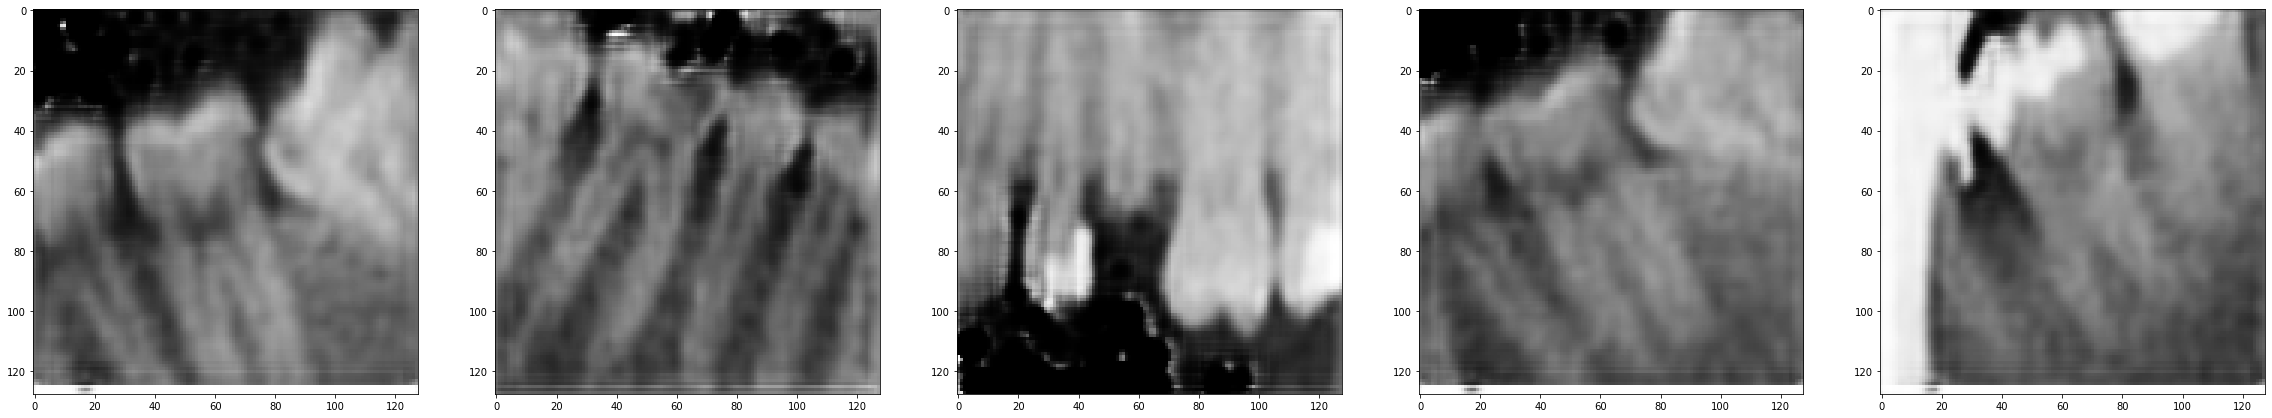

In [68]:
show_img(pred)

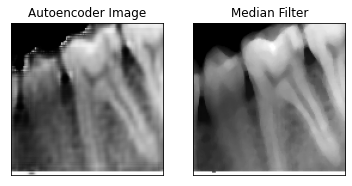

In [46]:
new_image = cv2.medianBlur(xtrain[2], (5))
plt.figure(figsize=(6,3))
plt.subplot(121)
plt.imshow(pred[2].reshape(128,128), cmap='gray')
plt.title('Autoencoder Image')
plt.xticks([])
plt.yticks([])
plt.subplot(122)
plt.imshow(new_image, cmap='gray')
plt.title('Median Filter')
plt.xticks([])
plt.yticks([])
plt.show()